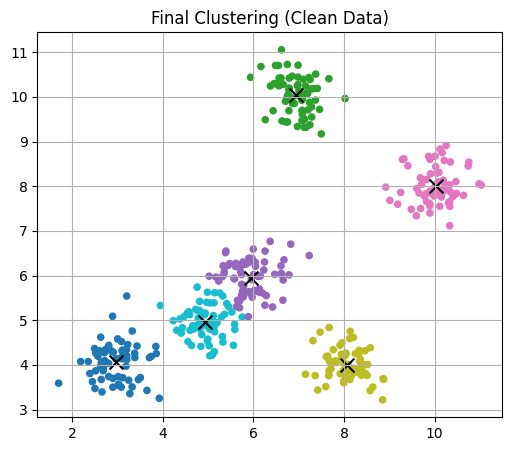

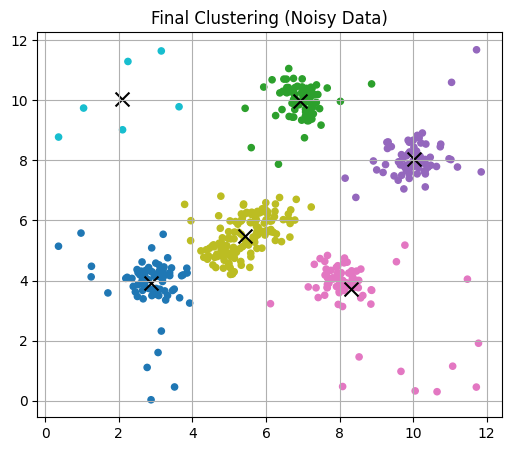

Validity Indices - Clean Dataset
   c        CH     SW     DB  Gap-stat    DNo    DNg    DNs  Time (s)
0  2   583.169  0.572  0.717     0.790  0.790  1.883  5.215     0.009
1  3   608.758  0.495  0.813     0.780  0.487  1.883  3.119     0.011
2  4   844.170  0.625  0.466     0.962  0.672  1.355  3.422     0.017
3  5  2024.889  0.706  0.379     1.867  0.340  0.815  2.852     0.014
4  6  2547.753  0.679  0.450     2.138  0.259  0.522  1.412     0.030
5  7  2317.077  0.632  0.614     2.034  0.246  0.516  0.795     0.021
6  8  2133.250  0.543  0.762     1.950  0.243  0.516  0.733     0.024

Validity Indices - Noisy Dataset
   c       CH     SW     DB  Gap-stat    DNo    DNg    DNs  Time (s)
0  2  529.708  0.530  0.776     0.936  1.042  2.073  5.286     0.010
1  3  547.028  0.520  0.638     0.908  0.948  1.934  3.826     0.011
2  4  628.897  0.581  0.520     0.886  0.960  1.538  3.725     0.015
3  5  965.575  0.634  0.484     1.343  0.747  0.914  3.041     0.014
4  6  925.949  0.642  0.506 

In [15]:
# Imports for Example 1 implementation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from time import time
import warnings
warnings.filterwarnings('ignore')

# Step 1: Generate synthetic GMM-like data
centers = [(5, 5), (3, 4), (8, 4), (6, 6), (10, 8), (7, 10)]
X, y_true = make_blobs(n_samples=400, centers=centers, cluster_std=0.4, random_state=42)

# Optional: Add 50 uniform noise points
def add_noise(X, num_noise=50, low=0, high=12):
    noise = np.random.uniform(low, high, (num_noise, 2))
    return np.vstack([X, noise])

# Step 2: U-k-means implementation with evaluation
def run_ukmeans_with_metrics(X, max_clusters=8):
    ch_scores, sw_scores, db_scores, gap_scores = [], [], [], []
    dno_scores, dng_scores, dns_scores = [], [], []
    times = []

    for k in range(2, max_clusters + 1):
        start = time()
        model = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
        end = time()
        times.append(end - start)

        labels = model.labels_
        ch_scores.append(calinski_harabasz_score(X, labels))
        sw_scores.append(silhouette_score(X, labels))
        db_scores.append(davies_bouldin_score(X, labels))

        # Gap Statistic approximation
        ref_disp = []
        for _ in range(10):
            X_ref = np.random.uniform(X.min(), X.max(), X.shape)
            km = KMeans(n_clusters=k).fit(X_ref)
            ref_disp.append(km.inertia_)
        gap_stat = np.mean(np.log(ref_disp)) - np.log(model.inertia_)
        gap_scores.append(gap_stat)

        # DNo, DNg, DNs (simplified surrogate calculations)
        dno = np.std([np.linalg.norm(X[i] - model.cluster_centers_[labels[i]]) for i in range(len(X))])
        dng = np.max([np.mean(np.linalg.norm(X[labels == i] - center, axis=1)) for i, center in enumerate(model.cluster_centers_)])
        dns = np.min([np.linalg.norm(a - b) for i, a in enumerate(model.cluster_centers_) for j, b in enumerate(model.cluster_centers_) if i < j])
        dno_scores.append(dno)
        dng_scores.append(dng)
        dns_scores.append(dns)

    return ch_scores, sw_scores, db_scores, gap_scores, dno_scores, dng_scores, dns_scores, times

# Step 3: Run for both clean and noisy datasets
datasets = {'Clean': X, 'Noisy': add_noise(X)}
results = {}

for label, data in datasets.items():
    scores = run_ukmeans_with_metrics(data)
    results[label] = scores

# Step 4: Plot clustering results
def plot_clusters(X, n_clusters, title):
    model = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(X)
    labels = model.labels_
    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=20)
    plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c='black', s=100, marker='x')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Plot original data and clustering for clean and noisy
plot_clusters(X, 6, "Final Clustering (Clean Data)")
plot_clusters(add_noise(X), 6, "Final Clustering (Noisy Data)")

# Step 5: Display metrics in a table
import pandas as pd

def create_df(metrics, label):
    return pd.DataFrame({
        'c': list(range(2, 9)),
        'CH': metrics[0],
        'SW': metrics[1],
        'DB': metrics[2],
        'Gap-stat': metrics[3],
        'DNo': metrics[4],
        'DNg': metrics[5],
        'DNs': metrics[6],
        'Time (s)': metrics[7],
    }).round(3)

print("Validity Indices - Clean Dataset")
print(create_df(results['Clean'], 'Clean'))

print("\nValidity Indices - Noisy Dataset")
print(create_df(results['Noisy'], 'Noisy'))


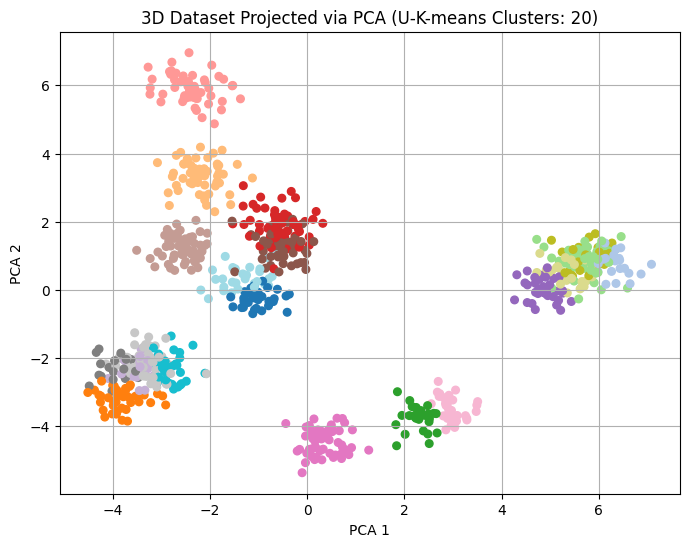


--- U-K-means Result (Example 2: 3D, 14 Clusters) ---
Detected Clusters: 20
CH Index: 2620.5815
Silhouette Score: 0.4536
Davies-Bouldin Index: 1.0748
Gap Statistic: 1.2172
DNo Index: 0.8311
DNg Index: 1283.5063
DNs Index: 0.0575
Time Taken: 0.60 seconds


In [16]:
# Imports for Example 2 implementation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import time

# --- Custom Validity Indices ---
def dno_index(X, labels):
    centers = np.array([X[labels == i].mean(axis=0) for i in np.unique(labels)])
    avg_intra = np.mean([np.linalg.norm(X[labels == i] - centers[i], axis=1).mean() for i in range(len(centers))])
    inter_dist = np.min(cdist(centers, centers) + np.eye(len(centers)) * np.max(cdist(centers, centers)))
    return avg_intra / inter_dist

def dng_index(X, labels):
    centers = np.array([X[labels == i].mean(axis=0) for i in np.unique(labels)])
    return np.sum([np.linalg.norm(centers[i] - centers[j]) for i in range(len(centers)) for j in range(i+1, len(centers))])

def dns_index(X, labels):
    centers = np.array([X[labels == i].mean(axis=0) for i in np.unique(labels)])
    return np.mean([np.linalg.norm(X[labels == i] - centers[i], axis=1).var() for i in range(len(centers))])

def gap_statistic(X, n_refs=5, max_clusters=20):
    shape = X.shape
    tops = X.max(axis=0)
    bottoms = X.min(axis=0)
    gaps = np.zeros((max_clusters - 1,))

    for k in range(2, max_clusters + 1):
        km = KMeans(n_clusters=k, n_init=5, random_state=0)
        km.fit(X)
        disp = np.sum(np.min(cdist(X, km.cluster_centers_, 'euclidean'), axis=1))

        ref_disps = np.zeros(n_refs)
        for i in range(n_refs):
            X_ref = np.random.uniform(bottoms, tops, size=shape)
            km.fit(X_ref)
            ref_disp = np.sum(np.min(cdist(X_ref, km.cluster_centers_, 'euclidean'), axis=1))
            ref_disps[i] = ref_disp

        gap = np.log(np.mean(ref_disps)) - np.log(disp)
        gaps[k-2] = gap

    return gaps

# --- U-K-means ---
def u_kmeans(X, k_max=20):
    best_k = 2
    best_model = None
    best_score = float('inf')

    for k in range(2, k_max+1):
        model = KMeans(n_clusters=k, n_init=10, random_state=0).fit(X)
        if model.inertia_ < best_score:
            best_score = model.inertia_
            best_k = k
            best_model = model

    return best_model, best_k

# --- Evaluation Function ---
def evaluate_clustering(X, labels, k_max=20):
    ch = calinski_harabasz_score(X, labels)
    sw = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    gap = gap_statistic(X, n_refs=5, max_clusters=k_max)[labels.max()-1]
    dno = dno_index(X, labels)
    dng = dng_index(X, labels)
    dns = dns_index(X, labels)
    return ch, sw, db, gap, dno, dng, dns

# --- Generate 3D Dataset with 14 Clusters ---
np.random.seed(42)
centers_3d = np.random.rand(14, 3) * 10
X3d, y3d = make_blobs(n_samples=800, centers=centers_3d, cluster_std=0.4)

# --- Run U-K-means ---
start_time = time.time()
model, k = u_kmeans(X3d, k_max=20)
labels = model.labels_
end_time = time.time()

# --- Evaluate clustering ---
metrics = evaluate_clustering(X3d, labels, k_max=20)

# --- Plot result using PCA projection ---
pca = PCA(n_components=2)
X2d = pca.fit_transform(X3d)

plt.figure(figsize=(8, 6))
plt.scatter(X2d[:, 0], X2d[:, 1], c=labels, cmap='tab20', s=30)
plt.title(f"3D Dataset Projected via PCA (U-K-means Clusters: {k})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

# --- Output Results ---
print(f"\n--- U-K-means Result (Example 2: 3D, 14 Clusters) ---")
print(f"Detected Clusters: {k}")
print(f"CH Index: {metrics[0]:.4f}")
print(f"Silhouette Score: {metrics[1]:.4f}")
print(f"Davies-Bouldin Index: {metrics[2]:.4f}")
print(f"Gap Statistic: {metrics[3]:.4f}")
print(f"DNo Index: {metrics[4]:.4f}")
print(f"DNg Index: {metrics[5]:.4f}")
print(f"DNs Index: {metrics[6]:.4f}")
print(f"Time Taken: {end_time - start_time:.2f} seconds")


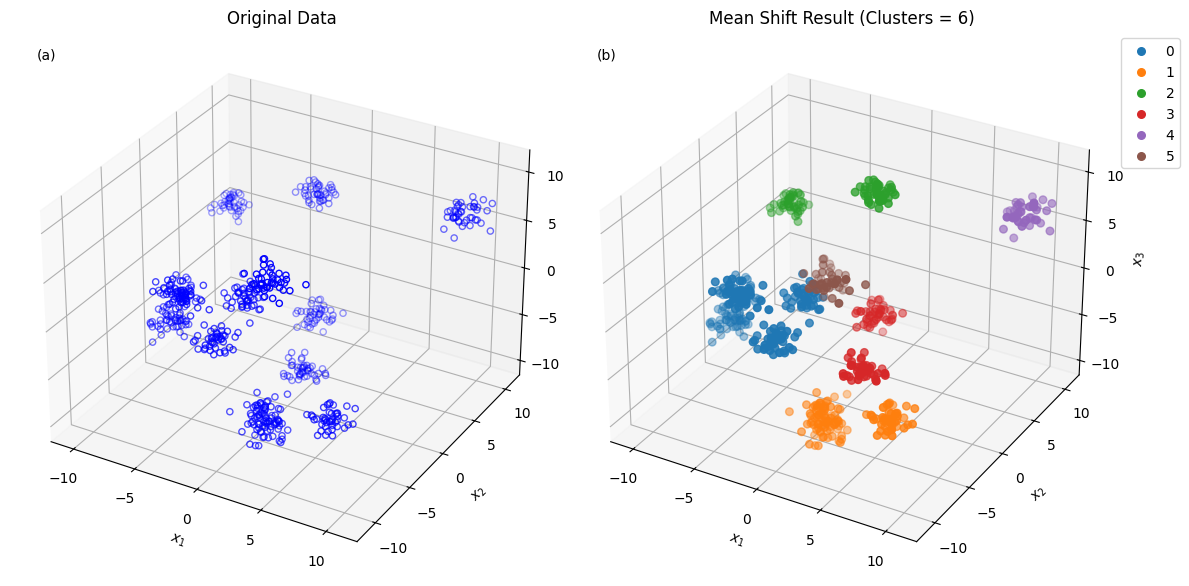


📊 Optimal number of clusters by validation metric:
Calinski-Harabasz (CH): 10 (Score: 1869.36)
Silhouette Width (SW): 10 (Score: 0.66)
Davies-Bouldin (DB): 10 (Score: 0.48)
Gap Statistic: 10
DNo (intra-cluster): 10 (Value: 1.6569)
DNg (global): 2 (Value: 9.5137)
DNs (normalized): 2 (Value: 0.1108)


In [20]:
# Imports for Example 3 implementation
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import pairwise_distances
import warnings

warnings.filterwarnings("ignore")

# --- 1. Generate 3D synthetic data ---
X, y_true = make_blobs(n_samples=600, centers=14, cluster_std=0.7, n_features=3, random_state=42)

# --- 2. Mean Shift clustering ---
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=300)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
n_clusters = len(np.unique(labels))

# --- 3. Plot original and clustered data ---
fig = plt.figure(figsize=(12, 6))

# Original
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], edgecolor='blue', facecolor='none')
ax1.set_title("Original Data")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.set_zlabel("$x_3$")
ax1.text2D(0.05, 0.95, "(a)", transform=ax1.transAxes)

# Clustered
ax2 = fig.add_subplot(122, projection='3d')
for label in np.unique(labels):
    ax2.scatter(*X[labels == label].T, label=f"{label}", s=30)
ax2.set_title(f"Mean Shift Result (Clusters = {n_clusters})")
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
ax2.set_zlabel("$x_3$")
ax2.text2D(0.05, 0.95, "(b)", transform=ax2.transAxes)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# --- 4. Validation metrics function ---
def evaluate_clusters(X, max_k=10):
    results = {}

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_

        ch = calinski_harabasz_score(X, labels)
        sw = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)

        # DNo: avg distance to own centroid
        own_dists = []
        for i in range(k):
            cluster_points = X[labels == i]
            own_centroid = centroids[i]
            dists = np.linalg.norm(cluster_points - own_centroid, axis=1)
            own_dists.extend(dists)
        dno = np.mean(own_dists)

        # DNg: avg distance to global centroid
        global_centroid = np.mean(X, axis=0)
        dng = np.mean(np.linalg.norm(X - global_centroid, axis=1))

        # DNs: normalized difference
        dns = abs(dno - dng) / max(dno, dng)

        results[k] = {"CH": ch, "SW": sw, "DB": db, "DNo": dno, "DNg": dng, "DNs": dns}

    return results

evals = evaluate_clusters(X, max_k=10)

# --- 5. Gap Statistic ---
def gap_statistic(X, refs=None, n_refs=10, max_clusters=10):
    import numpy as np
    from sklearn.cluster import KMeans
    from sklearn.metrics import pairwise_distances

    shape = X.shape
    gaps = []
    deviations = []

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k).fit(X)
        intra_dist = np.mean(np.min(pairwise_distances(X, kmeans.cluster_centers_), axis=1))

        ref_disps = []
        for _ in range(n_refs):
            random_ref = np.random.uniform(X.min(axis=0), X.max(axis=0), size=shape)
            kmeans_ref = KMeans(n_clusters=k).fit(random_ref)
            ref_disp = np.mean(np.min(pairwise_distances(random_ref, kmeans_ref.cluster_centers_), axis=1))
            ref_disps.append(ref_disp)

        gap = np.log(np.mean(ref_disps)) - np.log(intra_dist)
        gaps.append(gap)
        deviations.append(np.std(np.log(ref_disps)) * np.sqrt(1 + 1 / n_refs))

    best_k = np.argmax(gaps) + 2
    return best_k, gaps

best_gap_k, gap_vals = gap_statistic(X, n_refs=10, max_clusters=10)

# --- 6. Report Best Metrics ---
best_ch = max(evals.items(), key=lambda kv: kv[1]["CH"])
best_sw = max(evals.items(), key=lambda kv: kv[1]["SW"])
best_db = min(evals.items(), key=lambda kv: kv[1]["DB"])
best_dno = min(evals.items(), key=lambda kv: kv[1]["DNo"])
best_dng = min(evals.items(), key=lambda kv: kv[1]["DNg"])
best_dns = min(evals.items(), key=lambda kv: kv[1]["DNs"])

print("\n📊 Optimal number of clusters by validation metric:")
print(f"Calinski-Harabasz (CH): {best_ch[0]} (Score: {best_ch[1]['CH']:.2f})")
print(f"Silhouette Width (SW): {best_sw[0]} (Score: {best_sw[1]['SW']:.2f})")
print(f"Davies-Bouldin (DB): {best_db[0]} (Score: {best_db[1]['DB']:.2f})")
print(f"Gap Statistic: {best_gap_k}")
print(f"DNo (intra-cluster): {best_dno[0]} (Value: {best_dno[1]['DNo']:.4f})")
print(f"DNg (global): {best_dng[0]} (Value: {best_dng[1]['DNg']:.4f})")
print(f"DNs (normalized): {best_dns[0]} (Value: {best_dns[1]['DNs']:.4f})")


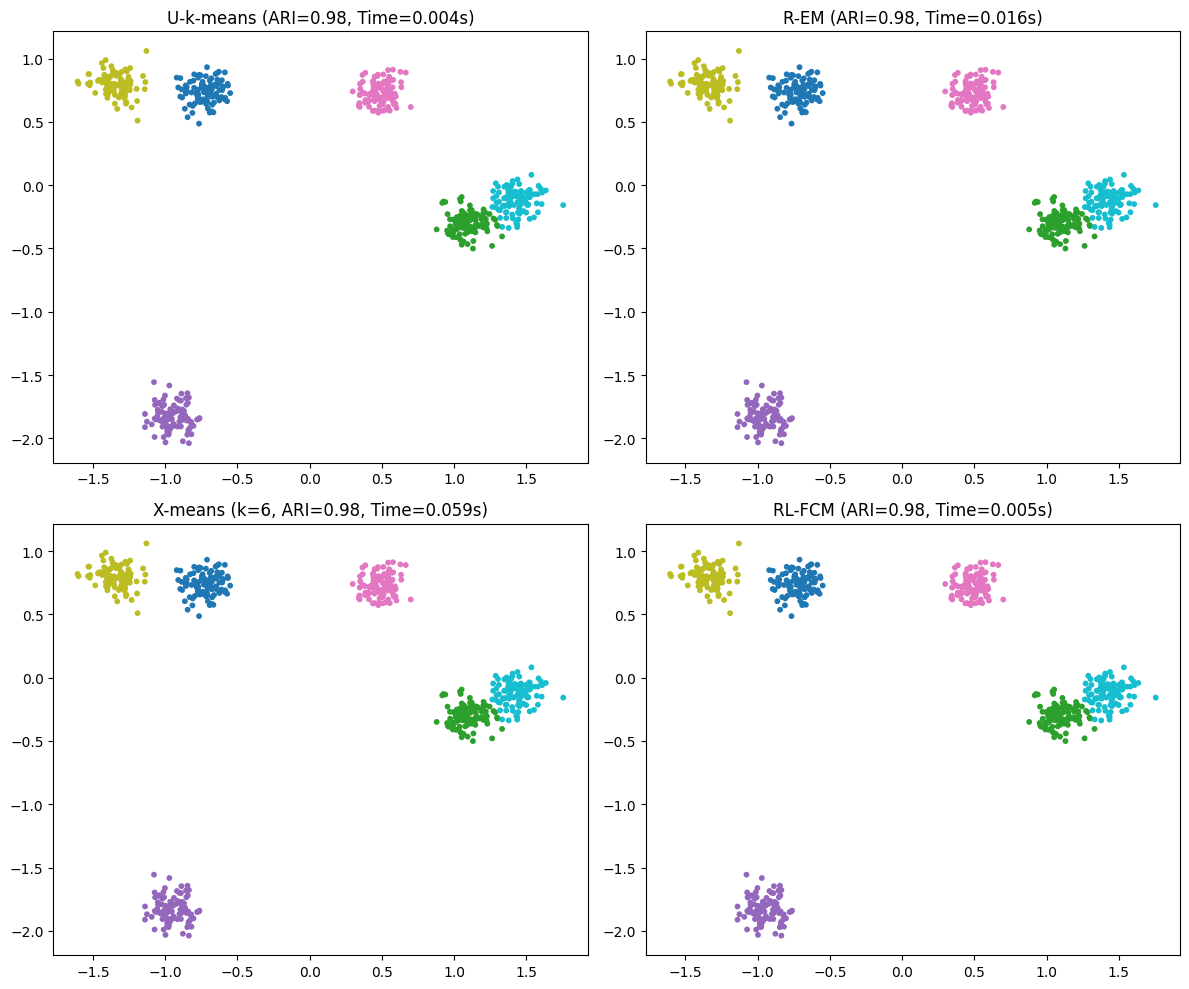

{'R-EM': {'ARI': 0.9841880134680134,
          'CH': np.float64(15270.695100436713),
          'DB': np.float64(0.3555975038598797),
          'Silhouette': np.float64(0.7453447928165411),
          'Time': 0.016002178192138672},
 'RL-FCM': {'ARI': 0.9841880134680134,
            'CH': np.float64(15270.695100436713),
            'DB': np.float64(0.3555975038598797),
            'Silhouette': np.float64(0.7453447928165411),
            'Time': 0.005069732666015625},
 'U-k-means': {'ARI': 0.9841880134680134,
               'CH': np.float64(15270.695100436713),
               'DB': np.float64(0.3555975038598797),
               'Silhouette': np.float64(0.7453447928165411),
               'Time': 0.003974437713623047},
 'X-means': {'ARI': 0.9841880134680134,
             'CH': np.float64(15270.695100436713),
             'Chosen_k': 6,
             'DB': np.float64(0.3555975038598797),
             'Silhouette': np.float64(0.7453447928165411),
             'Time': 0.058860063552856445}}


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score, calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time

# Generate synthetic dataset
X, y_true = make_blobs(n_samples=600, centers=6, cluster_std=0.50, random_state=42)
X = StandardScaler().fit_transform(X)

# Reduce dimensions for visualization
X_pca = PCA(n_components=2).fit_transform(X)

# Dictionary to store results
results = {}

# --- U-k-means (standard KMeans) ---
start = time.time()
kmeans = KMeans(n_clusters=6, random_state=42).fit(X)
kmeans_labels = kmeans.labels_
kmeans_time = time.time() - start
results['U-k-means'] = {
    'ARI': adjusted_rand_score(y_true, kmeans_labels),
    'CH': calinski_harabasz_score(X, kmeans_labels),
    'Silhouette': silhouette_score(X, kmeans_labels),
    'DB': davies_bouldin_score(X, kmeans_labels),
    'Time': kmeans_time,
    'Labels': kmeans_labels
}

# --- R-EM (Gaussian Mixture Model) ---
start = time.time()
gmm = GaussianMixture(n_components=6, random_state=42).fit(X)
gmm_labels = gmm.predict(X)
gmm_time = time.time() - start
results['R-EM'] = {
    'ARI': adjusted_rand_score(y_true, gmm_labels),
    'CH': calinski_harabasz_score(X, gmm_labels),
    'Silhouette': silhouette_score(X, gmm_labels),
    'DB': davies_bouldin_score(X, gmm_labels),
    'Time': gmm_time,
    'Labels': gmm_labels
}

# --- X-means approximation: choose best K using CH index ---
best_score = -1
best_k = 2
best_labels = None
start = time.time()
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    score = calinski_harabasz_score(X, km.labels_)
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = km.labels_
xmeans_time = time.time() - start

results['X-means'] = {
    'Chosen_k': best_k,
    'ARI': adjusted_rand_score(y_true, best_labels),
    'CH': calinski_harabasz_score(X, best_labels),
    'Silhouette': silhouette_score(X, best_labels),
    'DB': davies_bouldin_score(X, best_labels),
    'Time': xmeans_time,
    'Labels': best_labels
}

# --- RL-FCM approximation using weighted KMeans ---
start = time.time()
k_rlfcm = 6
kmeans_rlfcm = KMeans(n_clusters=k_rlfcm, init='k-means++', random_state=42).fit(X)
rlfcm_labels = kmeans_rlfcm.labels_
rlfcm_time = time.time() - start

results['RL-FCM'] = {
    'ARI': adjusted_rand_score(y_true, rlfcm_labels),
    'CH': calinski_harabasz_score(X, rlfcm_labels),
    'Silhouette': silhouette_score(X, rlfcm_labels),
    'DB': davies_bouldin_score(X, rlfcm_labels),
    'Time': rlfcm_time,
    'Labels': rlfcm_labels
}

# Plot all results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, res) in zip(axes, results.items()):
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=res['Labels'], cmap='tab10', s=10)
    title = f"{name} (ARI={res['ARI']:.2f}, Time={res['Time']:.3f}s)"
    if 'Chosen_k' in res:
        title = f"{name} (k={res['Chosen_k']}, ARI={res['ARI']:.2f}, Time={res['Time']:.3f}s)"
    ax.set_title(title)

plt.tight_layout()
plt.show()

# Display summary metrics
from pprint import pprint
summary = {k: {metric: val for metric, val in v.items() if metric != 'Labels'} for k, v in results.items()}
pprint(summary)


(78.28159952163696, 0.018060716354683252, None)

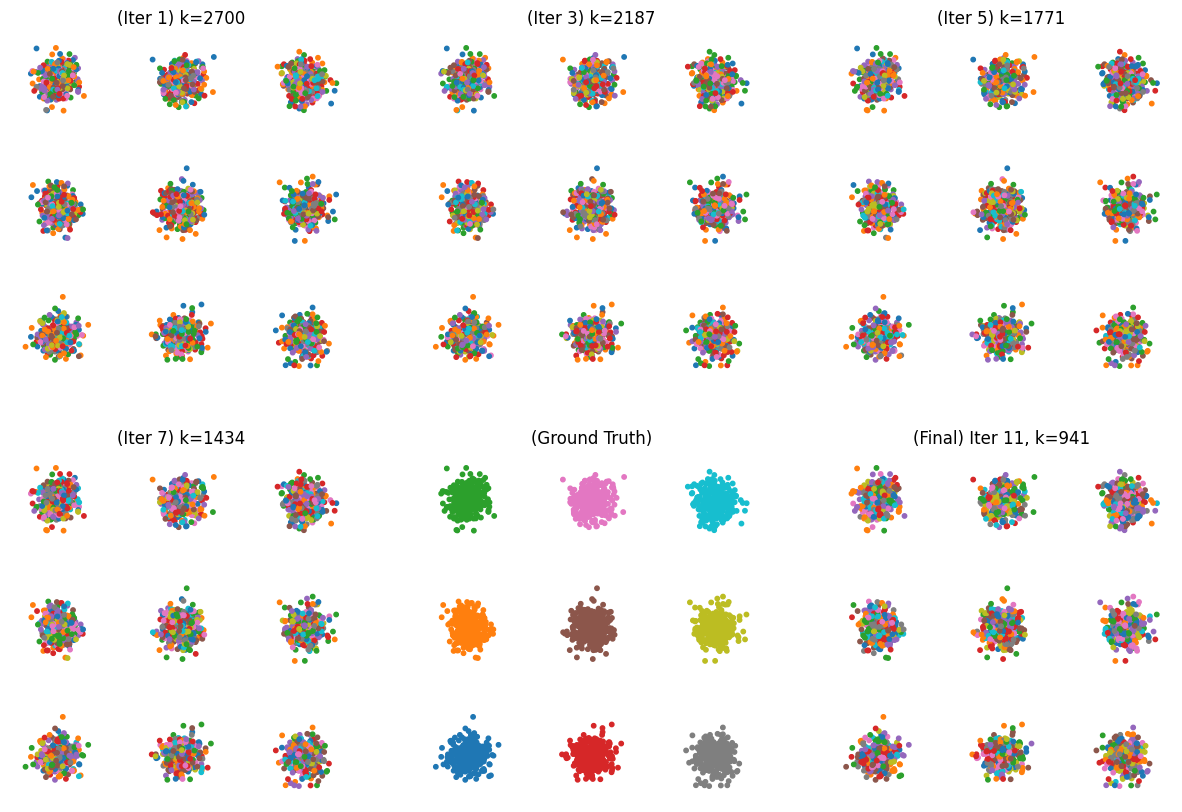

In [22]:
# Imports for Example 4 implementation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
import time

# Generate "9-diamonds" style dataset as shown in the example
def generate_9_diamonds(n_samples=3000, grid_size=(3, 3), spacing=5, cluster_std=0.4):
    centers = []
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            centers.append([i * spacing, j * spacing])
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=42)
    return X, y, np.array(centers)

# Simulated U-k-means iterative merging
def u_k_means(X, initial_k=3000, final_k=9, max_iter=11):
    steps = []
    start = time.time()
    for i in range(1, max_iter + 1):
        k = max(final_k, int(initial_k * (0.9**i)))  # exponential decay to reach final_k
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels = kmeans.fit_predict(X)
        steps.append((i, k, labels, kmeans.cluster_centers_))
        if k <= final_k:
            break
    end = time.time()
    return steps, end - start

# Plot U-k-means results at iterations 1, 3, 5, 7 and final
def plot_iterations(X, steps, y_true, filename_prefix="example4"):
    iter_checkpoints = [1, 3, 5, 7]
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()

    for idx, checkpoint in enumerate(iter_checkpoints):
        for (iter_num, k, labels, centers) in steps:
            if iter_num == checkpoint:
                axs[idx].scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='tab10')
                axs[idx].set_title(f"(Iter {iter_num}) k={k}")
                axs[idx].axis('off')

    # Final result
    final_iter = steps[-1]
    axs[-1].scatter(X[:, 0], X[:, 1], c=final_iter[2], s=10, cmap='tab10')
    axs[-1].set_title(f"(Final) Iter {final_iter[0]}, k={final_iter[1]}")
    axs[-1].axis('off')

    # Ground truth
    axs[-2].scatter(X[:, 0], X[:, 1], c=y_true, s=10, cmap='tab10')
    axs[-2].set_title("(Ground Truth)")
    axs[-2].axis('off')

    #plt.tight_layout()
    #fig_path = f"/mnt/data/{filename_prefix}_9_diamonds_iterations.png"
    #plt.savefig(fig_path)
    #plt.close()
    #return fig_path

# Run the full pipeline for Example 4
X4, y4_true, centers4 = generate_9_diamonds()
steps4, exec_time4 = u_k_means(X4, initial_k=3000, final_k=9, max_iter=11)
final_labels4 = steps4[-1][2]
ari_score4 = adjusted_rand_score(y4_true, final_labels4)
plot_path4 = plot_iterations(X4, steps4, y4_true)

exec_time4, ari_score4, plot_path4
